# Fourier Properties 2D
---
**Notebook 3 — 2026**
<div style="font-size:15px; padding:8px; margin:2px; font-weight:600; background-color:#E80808; color:white;text-align:center;">
    <div style=" ">
        Introduction to Multidimensional Fourier Transform
    </div>
</div>
<div style="border-bottom: 1px gray dotted; padding:8px;margin:2px;text-align:center; font-size:15px; color:#444;">
<i>Daniel Sage — École Polytechnique Fédérale de Lausanne (EPFL)</i>
</div>

**Important notice**: These interactive notebooks complement the lecture and are not self-contained; in-class explanations are required.

In [12]:
import numpy as np, matplotlib.pyplot as plt
from skimage import data, transform, io
from ipywidgets import interact, IntSlider, FloatSlider, Dropdown
from matplotlib.patches import Circle
from skimage.filters import gaussian
from skimage.transform import rotate

#img = data.camera()
img = io.imread('car_pad.tif')
size=128
img = transform.resize(img, (size,size), anti_aliasing=True)

def fft2c(x): return np.fft.fftshift(np.fft.fft2(x))
def ifft2c(F): return np.real(np.fft.ifft2(np.fft.ifftshift(F)))
def snr(x,y): return 10*np.log10(np.mean(x*x)/(np.mean((x-y)**2)+1e-12))
def radial_grid(n):a=(np.arange(n)-n//2)/n; X,Y=np.meshgrid(a,a); return np.sqrt(X*X+Y*Y)
def showim(ax,img,t,vmin=None,vmax=None):
    ax.imshow(img,cmap="gray",vmin=vmin,vmax=vmax); ax.set_title(t,fontsize=16); ax.axis("off")
def showFM(ax,F,t):
    ax.imshow(np.log(np.abs(F)+1e-12),cmap="gray"); ax.set_title(t,fontsize=16); ax.axis("off")
def plotsig(ax, x, s, title):
    ax.plot(x, s); ax.set_title(title); ax.grid(True, lw=.4, color="0.85"); ax.margins(0.01)
def plotFM(ax, x, s, title):
    rs = np.abs(s)+1e-12; ax.plot(x, rs); ax.set_title(title); ax.set_yscale("log"); ax.grid(True, lw=.4, color="0.85"); ax.margins(0.01)

## 3.1 Geometrical transformation

In [2]:
@interact(scale=FloatSlider(min=0.5,max=3,step=0.1,value=1),
          shiftx=IntSlider(min=-20,max=20,step=5,value=0), shifty=IntSlider(min=-20,max=20,step=5,value=0),
          angle=FloatSlider(min=0,max=180,step=5,value=0), elongation=FloatSlider(min=0.25,max=4,step=0.1,value=2))
def geometrical(scale, shiftx, shifty, angle, elongation):
    img0 = np.zeros((size,size))
    h,w = int(5/elongation*scale), int(5*elongation*scale)
    cy,cx = size//2+shifty, size//2+shiftx; img0[cy-h:cy+h, cx-w:cx+w] = 1
    img0 = gaussian(img0, sigma=1)
    img0 = rotate(img0, angle, resize=False, order=1, mode="constant")
    F = fft2c(img0)
    fig,ax=plt.subplots(1,3,figsize=(12,4))
    showim(ax[0], img0, "Image")
    showFM(ax[1], F, "FFT magnitude")
    showFM(ax[2], np.exp(1j*np.angle(F)), "FFT phase")
    plt.show()

interactive(children=(FloatSlider(value=1.0, description='scale', max=3.0, min=0.5), IntSlider(value=0, descri…

## 3.2 Phase importance

In [3]:
@interact(image2=Dropdown(options=["camera","car_pad","random"],value="camera"))
def phase_demo(image2):
    img1 = img
    if image2=="camera": x=data.camera()
    elif image2=="car_pad": x=io.imread("car_pad.tif", as_gray=True)
    else: x=np.random.rand(size,size)
    img2 = transform.resize(x,(size,size),anti_aliasing=True)
    F1, F2 = fft2c(img1), fft2c(img2)
    M1, P1 = np.abs(F1), np.angle(F1); M2, P2 = np.abs(F2), np.angle(F2)
    R12 = ifft2c(M1*np.exp(1j*P2)); R22 = ifft2c(M2*np.exp(1j*P1))
    fig,ax = plt.subplots(2,4,figsize=(14,7))
    showim(ax[0,0],img1,"Image 1"); showFM(ax[0,1],M1,"|F1|")
    showFM(ax[0,2],np.exp(1j*P1),"Phase 1"); showim(ax[0,3],R12,"|F1| + Phase 2")
    showim(ax[1,0],img2,"Image 2"); showFM(ax[1,1],M2,"|F2|")
    showFM(ax[1,2],np.exp(1j*P2),"Phase 2"); showim(ax[1,3],R22,"|F2| + Phase 1")
    plt.show()

interactive(children=(Dropdown(description='image2', options=('camera', 'car_pad', 'random'), value='camera'),…

## 3.3 Filtering

In [4]:
F0 = fft2c(img); R  = radial_grid(size); rmax = R.max()

@interact(low=FloatSlider(min=0,max=0.5,step=0.01,value=0.05), high=FloatSlider(min=0,max=0.5,step=0.01,value=0.20))
def fourier_filter(low, high):
    LP = R <= low*rmax; HP = R >= high*rmax;  BP = (R > low*rmax) & (R < high*rmax)
    FL = F0 * LP; FB = F0 * BP; FH = F0 * HP
    il = ifft2c(FL); ib = ifft2c(FB); ih = ifft2c(FH); isum = il + ib + ih

    fig,ax = plt.subplots(3,4,figsize=(14,10))
    showim(ax[0,0], img, "Image")
    showFM(ax[0,1], LP, "LP mask")
    showFM(ax[0,2], BP, "BP mask")
    showFM(ax[0,3], HP, "HP mask")
    showim(ax[1,1], il, f"LP  SNR={snr(img,il):.2f} dB")
    showim(ax[1,2], ib, f"BP  SNR={snr(img,ib):.2f} dB")
    showim(ax[1,3], ih, f"HP  SNR={snr(img,ih):.2f} dB")
    showim(ax[1,0], isum, f"LP+BP+HP  SNR={snr(img,isum):.2f} dB")
    showFM(ax[2,0], F0, "FFT Imaeg")
    showFM(ax[2,1], FL, "FFT LP")
    showFM(ax[2,2], FB, "FFT BP")
    showFM(ax[2,3], FH, "FFT HP")
    plt.show()

interactive(children=(FloatSlider(value=0.05, description='low', max=0.5, step=0.01), FloatSlider(value=0.2, d…

## 3.4 Modulation

In [5]:
@interact(period=FloatSlider(min=2, max=64, step=1, value=16), angle=FloatSlider(min=0, max=2*np.pi, step=0.05, value=0))
def modulation(period, angle):
    img0 = img - img.mean()
    y, x = np.meshgrid(np.arange(size), np.arange(size), indexing="ij")
    fx, fy = np.cos(angle)/period, np.sin(angle)/period
    wave = np.cos(2*np.pi*(fx*x + fy*y))
    mod = img0 * wave

    fig, ax = plt.subplots(2,3, figsize=(14,7))
    showim(ax[0,0], img0, "Zero-mean image")
    showim(ax[0,1], wave, f"Wave (period={period:3.1f})")
    showim(ax[0,2], mod, "Modulated")
    showFM(ax[1,0], fft2c(img0), "FFT image")
    showFM(ax[1,1], fft2c(wave), "FFT wave")
    showFM(ax[1,2], fft2c(mod), "FFT modulated")
    plt.show()

interactive(children=(FloatSlider(value=16.0, description='period', max=64.0, min=2.0, step=1.0), FloatSlider(…

## 3.5 Fourier-domain differentiation

In [6]:
F0 = fft2c(img)
f = (np.arange(size) - size//2)/size
FX, FY = np.meshgrid(f, f, indexing="ij")
R = np.sqrt(FX**2 + FY**2) + 1e-12

@interact(alpha=FloatSlider(min=0, max=5, step=0.1, value=1), mode=Dropdown(options=["x","y","isotropic"], value="isotropic"))
def differentiate(alpha, mode):
    if mode=="x": H = (1j*2*np.pi*FX)**alpha
    elif mode=="y": H = (1j*2*np.pi*FY)**alpha
    else: H = (1j*2*np.pi*R)**alpha
    r = ifft2c(F0*H)

    fig, ax = plt.subplots(1,4,figsize=(28,7))
    showim(ax[0], img, f"Image")
    v = np.max(np.abs(r))
    showim(ax[1], r, f"Reconstruction  α={alpha}")
    showFM(ax[2], H, "FFT filter")
    if mode=="isotropic":
        plotFM(ax[3], f[f>=0], np.abs(H[size//2, f>=0]), "Filter profile |ω|"); 
        ax[3].set_yscale("linear");
    else: 
        ax[3].axis("off")
    plt.show()

interactive(children=(FloatSlider(value=1.0, description='alpha', max=5.0), Dropdown(description='mode', index…

## 3.6 Radial Fourier energy

In [7]:
F0 = fft2c(img)
R = radial_grid(size)

@interact(sigma_noise=FloatSlider(min=0,max=0.5,step=0.05,value=0.05))
def noise_radial(sigma_noise):
    noisy = img + sigma_noise*np.random.randn(size,size)
    F = fft2c(noisy)
    bins = np.linspace(0, R.max(), size//2+1)
    rad = np.zeros(size//2); freq = np.zeros(size//2)
    for i in range(size//2):
        m = (R >= bins[i]) & (R < bins[i+1])
        rad[i] = np.mean(np.abs(F[m])**2)
        freq[i] = 0.5*(bins[i] + bins[i+1])

    fig,ax=plt.subplots(1,3,figsize=(15,5))
    showim(ax[0], noisy, f"Noisy image σ={sigma_noise}")
    showFM(ax[1], F, "FFT(noisy)")
    plotFM(ax[2], freq, rad, "Radial spectrum (log)")
    ax[2].set_ylim(1, 10e6);
    plt.show()

interactive(children=(FloatSlider(value=0.05, description='sigma_noise', max=0.5, step=0.05), Output()), _dom_…

## 3.7 Sampling / aliasing

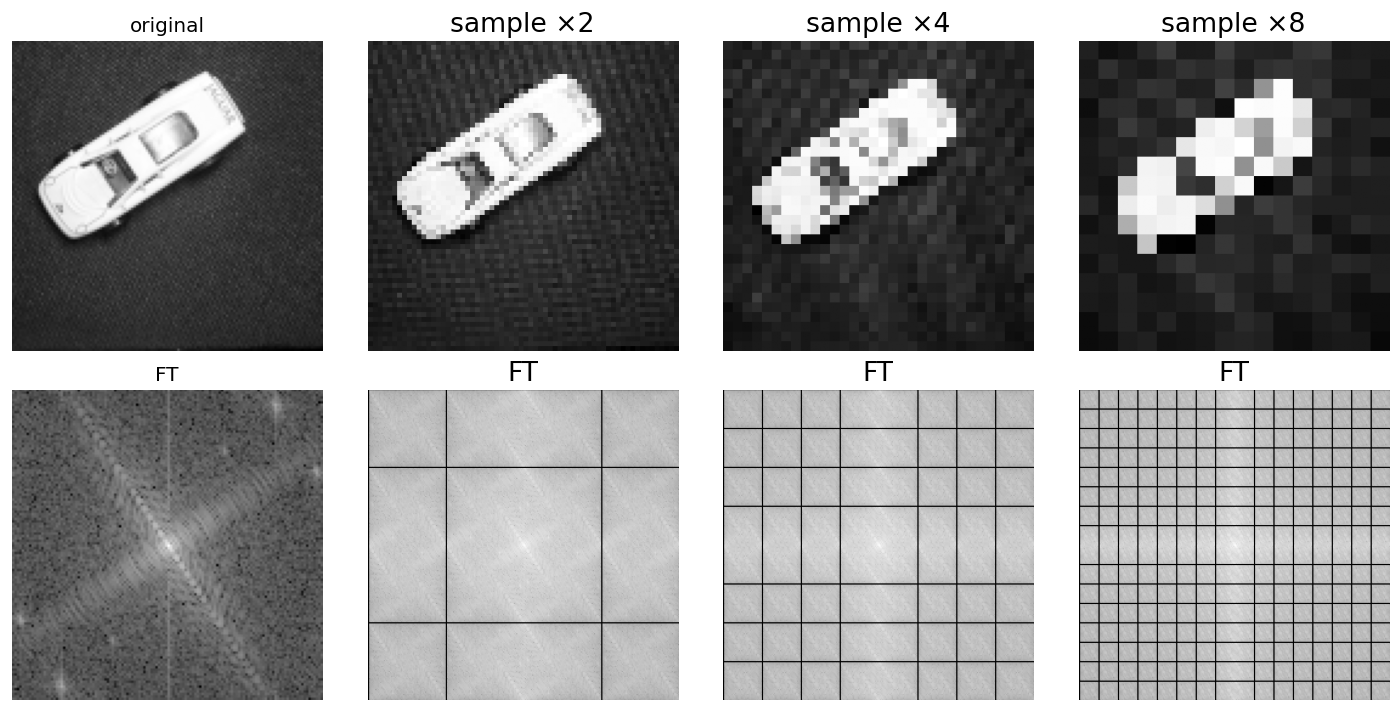

In [15]:
fig,ax=plt.subplots(2,4,figsize=(12,6))
show(ax[0,0],img,"original")
showF(ax[1,0],fft2c(img),"FT")

for i,s in enumerate([2,4,8]):
    d = img[::s,::s]
    d = transform.resize(d,(256,256),order=0,anti_aliasing=False)
    showim(ax[0,i+1],d,f"sample ×{s}")
    showFM(ax[1,i+1],fft2c(d),"FT")
plt.show()